## Drive Mount


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Install Libraries

In [2]:
#라이브러리 설치
!pip install pydub
!pip install onnxruntime
!pip install spafe
!pip install tf2onnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 121.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.0/94.0 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 455.8/455.8 kB 25.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 91.4 MB/s eta 0:00:00


## Import Libraries

In [3]:
import os
import pandas as pd
from tqdm import tqdm
import numpy as np
import librosa
from sklearn.model_selection import train_test_split
from scipy.io.wavfile import read
from spafe.features.lfcc import lfcc
from spafe.features.cqcc import cqcc
from spafe.utils.preprocessing import SlidingWindow
from spafe.utils.vis import show_features
import onnxruntime as ort
import numpy as np
import tensorflow as tf
import tf2onnx
from spafe.features.lfcc import linear_spectrogram,lfcc
from spafe.utils.vis import show_spectrogram
from spafe.utils.preprocessing import SlidingWindow
from scipy.io.wavfile import read
from spafe.utils.vis import show_features


# Preprocess

## window_shift

In [4]:
from pydub import AudioSegment
import os

def split_wav_with_window_shift(file_path, file_name='test', window_size=5000, shift_size=1000, output_dir="output", sr=16000):

    if file_path[-3:] == "wav":
      audio = AudioSegment.from_wav(file_path)

    elif file_path[-3:] == "mp3":
      audio = AudioSegment.from_mp3(file_path)

    else:
      return 'please check your input file'

    # 출력 디렉토리 생성
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # 오디오 길이 (밀리초 단위)
    audio_length = len(audio)

    # 오디오 길이가 5초보다 짧으면 반복하여 5초 이상으로 늘리기
    if audio_length < window_size:
        repeat_count = window_size // audio_length + 1
        audio = audio * repeat_count
        audio = audio[:window_size]  # 5초로 자르기
        audio_length = len(audio)

    # 오디오를 window_size 간격으로 나누고 shift_size 만큼 이동
    for start in range(0, audio_length - window_size + 1, shift_size):
        end = start + window_size
        chunk = audio[start:end]

        # 파일 저장
        chunk_name = f"{output_dir}/chunk_{file_name}_{start // 1000}_{end // 1000}.wav"
        chunk.export(chunk_name, format="wav")
        print(f"Saved {chunk_name}")

    # 처음 1초에서 4초까지 부족한 부분을 반복으로 채우기
    for i in range(1, 5):

        chunk = audio[:i * 1000] * 5
        chunk = chunk[:5000]

        chunk_name = f"{output_dir}/chunk_{file_name}_0_{i}.wav"
        chunk.export(chunk_name, format="wav")
        print(f"Saved {chunk_name}")


## make dataset

In [5]:
import os

# 파일 경로와 레이블을 저장할 리스트 초기화
paths = []
labels = []

# 데이터셋이 저장된 루트 디렉토리 경로
root_dir = '/content/drive/MyDrive/KT_BP/Data/DeepVoiceDataset'

# 'Fake'라는 단어가 포함된 디렉토리 이름을 리스트로 저장
lst = [file for file in os.listdir(root_dir) if 'Fake' in file]

# 분할된 오디오 파일을 저장할 'Fake' 출력 디렉토리 경로
output_dir = "/content/Fake"

# 'Fake' 디렉토리 내의 각 서브디렉토리에 대해 작업 수행
for subdir in lst:
    subdir_path = os.path.join(root_dir, subdir)
    if os.path.isdir(subdir_path):  # 서브디렉토리가 존재하는지 확인
        for filename in os.listdir(subdir_path):  # 서브디렉토리 내의 각 파일에 대해 작업 수행
            file_path = os.path.join(subdir_path, filename)
            # 오디오 파일을 일정한 크기로 분할하여 출력 디렉토리에 저장
            split_wav_with_window_shift(
                file_path,
                window_size=5000,  # 윈도우 크기 (밀리초 단위)
                shift_size=1000,   # 시프트 크기 (밀리초 단위)
                output_dir=output_dir,
                file_name=filename
            )

# 'Real'이라는 단어가 포함된 디렉토리 이름을 리스트로 저장
lst = [file for file in os.listdir(root_dir) if 'Real' in file]

# 분할된 오디오 파일을 저장할 'Real' 출력 디렉토리 경로
output_dir = "/content/Real"

# 'Real' 디렉토리 내의 각 서브디렉토리에 대해 작업 수행
for subdir in lst:
    subdir_path = os.path.join(root_dir, subdir)
    if os.path.isdir(subdir_path):  # 서브디렉토리가 존재하는지 확인
        for filename in os.listdir(subdir_path):  # 서브디렉토리 내의 각 파일에 대해 작업 수행
            file_path = os.path.join(subdir_path, filename)
            # 오디오 파일을 일정한 크기로 분할하여 출력 디렉토리에 저장
            split_wav_with_window_shift(
                file_path,
                window_size=5000,  # 윈도우 크기 (밀리초 단위)
                shift_size=1000,   # 시프트 크기 (밀리초 단위)
                output_dir=output_dir,
                file_name=filename
            )


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
Saved /content/Real/chunk_Aivle_Adult_Male_1526756848_13824.wav_0_4.wav
Saved /content/Real/chunk_Aivle_Adult_Female_1526911029_24294.wav_0_5.wav
Saved /content/Real/chunk_Aivle_Adult_Female_1526911029_24294.wav_0_1.wav
Saved /content/Real/chunk_Aivle_Adult_Female_1526911029_24294.wav_0_2.wav
Saved /content/Real/chunk_Aivle_Adult_Female_1526911029_24294.wav_0_3.wav
Saved /content/Real/chunk_Aivle_Adult_Female_1526911029_24294.wav_0_4.wav
Saved /content/Real/chunk_Aivle_Adult_Male_1527329795_07134.wav_0_5.wav
Saved /content/Real/chunk_Aivle_Adult_Male_1527329795_07134.wav_0_1.wav
Saved /content/Real/chunk_Aivle_Adult_Male_1527329795_07134.wav_0_2.wav
Saved /content/Real/chunk_Aivle_Adult_Male_1527329795_07134.wav_0_3.wav
Saved /content/Real/chunk_Aivle_Adult_Male_1527329795_07134.wav_0_4.wav
Saved /content/Real/chunk_Aivle_Adult_Male_1527329795_07257.wav_0_5.wav
Saved /content/Real/chunk_Aivle_Adult_Male_1527329795_07257.wav_0_1.wav
Saved /content/Rea

## LFCC

In [ ]:
!pip install spafe #audio feature extractor

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.0/94.0 kB 2.8 MB/s eta 0:00:00


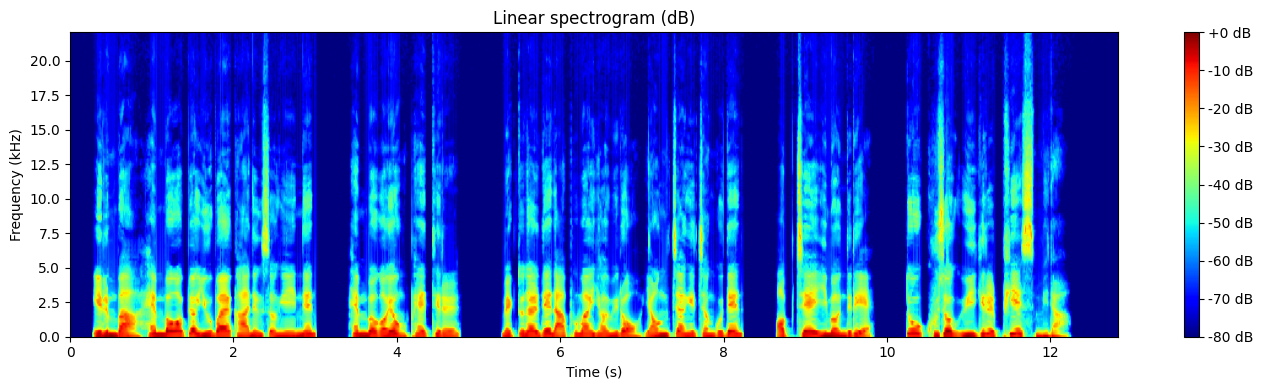

In [ ]:
from spafe.features.lfcc import linear_spectrogram
from spafe.utils.vis import show_spectrogram
from spafe.utils.preprocessing import SlidingWindow
from scipy.io.wavfile import read

# read audio
fpath = "/content/drive/MyDrive/KT_BP/Data/announcer_data/SPK003/SPK003YTNSO162F001.wav"
fs, sig = read(fpath)

# compute spectrogram
lSpec, lfreqs = linear_spectrogram(sig,
                                   fs=fs,
                                   pre_emph=0,
                                   pre_emph_coeff=0.97,
                                   window=SlidingWindow(0.03, 0.015, "hamming"),
                                   nfilts=128,
                                   nfft=2048,
                                   low_freq=0,
                                   high_freq=fs/2)

# visualize spectrogram
show_spectrogram(lSpec.T,
                 fs,
                 xmin=0,
                 xmax=len(sig)/fs,
                 ymin=0,
                 ymax=(fs/2)/1000,
                 dbf=80.0,
                 xlabel="Time (s)",
                 ylabel="Frequency (kHz)",
                 title="Linear spectrogram (dB)",
                 cmap="jet")

In [ ]:
lSpec.shape

(854, 128)

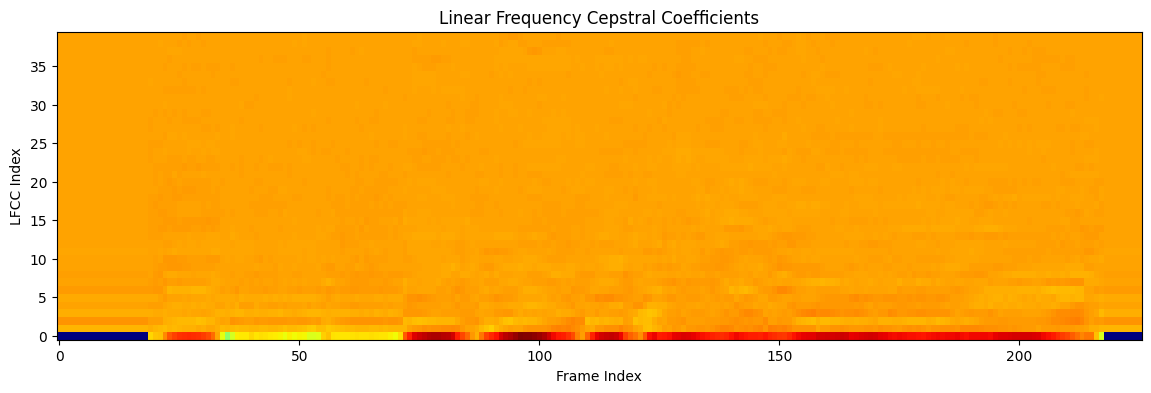

In [ ]:
from scipy.io.wavfile import read
from spafe.features.lfcc import lfcc
from spafe.utils.preprocessing import SlidingWindow
from spafe.utils.vis import show_features

# read audio
#real audio
fpath = "/content/drive/MyDrive/KT_BP/Data/DeepVoiceDataset/Real_child/Aivle_Child_female_1520668291-3_53758.wav"
fs, sig = read(fpath)

# compute lfccs
lfccs  = lfcc(sig,
              fs=fs,
              pre_emph=1,
              num_ceps=40,
              pre_emph_coeff=0.97,
              window=SlidingWindow(0.03, 0.015, "hamming"), #[hanning, bartlet, kaiser, blackman, hamming]
              nfilts=40,
              nfft=2048,
              low_freq=0,
              high_freq=8000,
              normalize="mvn")

# visualize features
show_features(lfccs, "Linear Frequency Cepstral Coefﬁcients", "LFCC Index", "Frame Index")

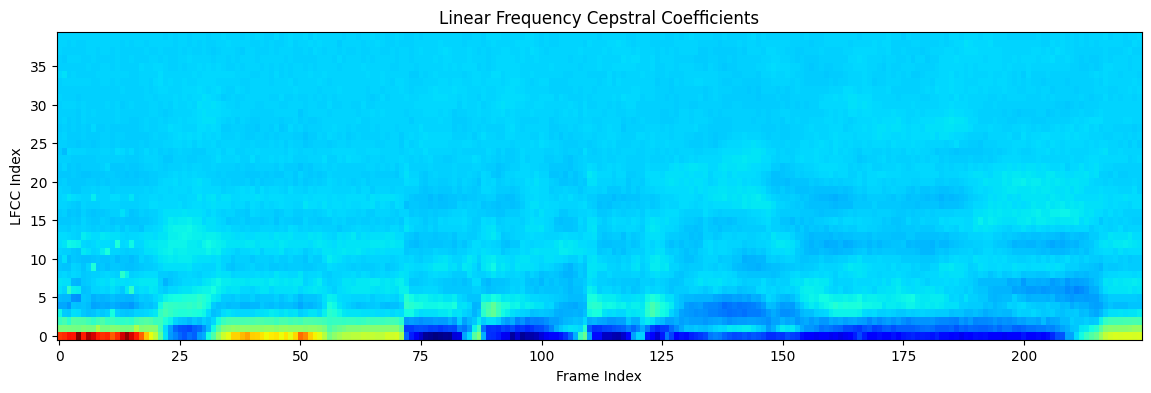

In [ ]:
from scipy.io.wavfile import read
from spafe.features.lfcc import lfcc
from spafe.utils.preprocessing import SlidingWindow
from spafe.utils.vis import show_features

# read audio
#real audio
fpath = "/content/drive/MyDrive/KT_BP/Data/DeepVoiceDataset/Fake_child/Aivle_Child_female_1520668291-3_53758_g.wav"
fs, sig = read(fpath)

# compute lfccs
lfccs  = lfcc(sig,
              fs=fs,
              pre_emph=1,
              num_ceps=40,
              pre_emph_coeff=0.97,
              window=SlidingWindow(0.03, 0.015, "hamming"), #[hanning, bartlet, kaiser, blackman, hamming]
              nfilts=40,
              nfft=2048,
              low_freq=0,
              high_freq=8000,
              normalize="mvn")





# visualize features
show_features(-lfccs, "Linear Frequency Cepstral Coefﬁcients", "LFCC Index", "Frame Index")

In [ ]:
lfccs.shape

(854, 40)

In [ ]:
import librosa
audio, _ = librosa.load(fpath, sr=16000)
# Extract features (example: using Mel-Frequency Cepstral Coefficients)
mfccs = librosa.feature.mfcc(y=audio, sr=16000, n_mfcc=40)

In [ ]:
mfccs.shape, mfccs

((40, 401),
 array([[-593.0443, -593.0443, -593.0443, ..., -593.0443, -593.0443,
         -593.0443],
        [   0.    ,    0.    ,    0.    , ...,    0.    ,    0.    ,
            0.    ],
        [   0.    ,    0.    ,    0.    , ...,    0.    ,    0.    ,
            0.    ],
        ...,
        [   0.    ,    0.    ,    0.    , ...,    0.    ,    0.    ,
            0.    ],
        [   0.    ,    0.    ,    0.    , ...,    0.    ,    0.    ,
            0.    ],
        [   0.    ,    0.    ,    0.    , ...,    0.    ,    0.    ,
            0.    ]], dtype=float32))

## CQCC

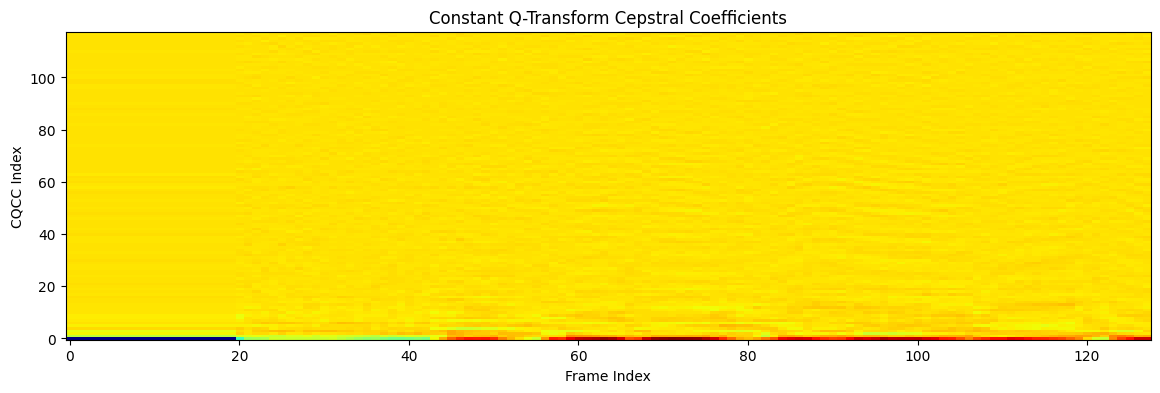

In [ ]:
from scipy.io.wavfile import read
from spafe.features.cqcc import cqcc
from spafe.utils.preprocessing import SlidingWindow
from spafe.utils.vis import show_features

# read audio
fpath = "/content/drive/MyDrive/KT_BP/Data/DeepVoiceDataset/Real_child/Aivle_Child_female_1522218484-0_18368.wav"
fs, sig = read(fpath)

# 설정된 프레임 수를 맞추기 위해 필요한 신호 길이 계산
desired_frames = 128
frame_length = int(0.03 * fs)  # 0.03초 윈도우 길이
frame_shift = int(0.0155 * fs)  # 0.0155초 프레임 간 시간차
signal_length = desired_frames * frame_shift + frame_length - frame_shift

# 신호 길이를 조정
if len(sig) < signal_length:
    sig = np.pad(sig, (0, signal_length - len(sig)), 'constant')
else:
    sig = sig[:signal_length]


# compute cqccs
cqccs  = cqcc(sig,
              fs=fs,
              num_ceps=128,
              pre_emph=1,
              pre_emph_coeff=0.97,
              window=SlidingWindow(0.03, 0.0155, "hamming"),
              nfft=2048,
              low_freq=0,
              high_freq=fs/2,
              normalize="mvn")

# visualize features
show_features(cqccs, "Constant Q-Transform Cepstral Coefﬁcients", "CQCC Index", "Frame Index")

In [ ]:
cqccs.shape

(128, 118)

## CODE

In [ ]:
# load data

paths = []
labels = []
root_dir = '/content/'
lst = [file for file in os.listdir(root_dir) if 'Fake' in file or 'Real' in file]

for subdir in lst:
    subdir_path = os.path.join(root_dir, subdir)
    if os.path.isdir(subdir_path):
        for filename in os.listdir(subdir_path):
            file_path = os.path.join(subdir_path, filename)
            paths.append(file_path)
            labels.append(subdir[:4])

print('Dataset is loaded')

Dataset is loaded


In [ ]:
lst

[]

In [ ]:
df = pd.DataFrame()
df['speech'] = paths
df['label'] = labels

In [ ]:
len(df)

0

## extract features (train_model)



In [6]:
def extract_features(audio_path, max_length=500, model='mfcc', n_fil=40):
    features = []
    labels = []

    # 'Fake' 또는 'Real'이 파일 이름에 포함된 디렉토리만 선택
    lst = [file for file in os.listdir(audio_path) if 'Fake' in file or 'Real' in file]

    for folder in lst:
        print(folder)
        folder_path = os.path.join(audio_path, folder)

        for file in tqdm(os.listdir(folder_path)):
            file_path = os.path.join(folder_path, file)

            try:
                if model == 'mfcc':
                    # 오디오 파일 로드
                    audio, _ = librosa.load(file_path, sr=16000)
                    # MFCC 특징 추출
                    mfccs = librosa.feature.mfcc(y=audio, sr=16000, n_mfcc=n_fil)

                    # 특징 배열을 고정 길이로 패딩 또는 자르기
                    if mfccs.shape[1] < max_length:
                        mfccs = np.pad(mfccs, ((0, 0), (0, max_length - mfccs.shape[1])), mode='constant')
                    else:
                        mfccs = mfccs[:, :max_length]

                    features.append(mfccs)

                elif model == 'lfcc':
                    fs, sig = read(file_path)
                    # LFCC 특징 추출
                    lfccs = lfcc(sig, fs=fs, pre_emph=1, num_ceps=n_fil, pre_emph_coeff=0.97,
                                 window=SlidingWindow(0.03, 0.015, "hamming"),
                                 nfilts=n_fil,
                                 nfft=2048,
                                 low_freq=0,
                                 high_freq=8000,
                                 normalize="mvn")
                    lfccs = lfccs.reshape(n_fil, -1)

                    if lfccs.shape[1] < max_length:
                        lfccs = np.pad(lfccs, ((0, 0), (0, max_length - lfccs.shape[1])), mode='constant')
                    else:
                        lfccs = lfccs[:, :max_length]

                    features.append(lfccs)

                elif model == 'mel':
                    # 오디오 파일 로드
                    audio, _ = librosa.load(file_path, sr=16000)
                    # Mel 스펙트로그램 추출
                    mel_spec = librosa.feature.melspectrogram(y=audio, sr=16000, n_mels=n_fil, hop_length=512)
                    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

                    if mel_spec_db.shape[1] < max_length:
                        mel_spec_db = np.pad(mel_spec_db, ((0, 0), (0, max_length - mel_spec_db.shape[1])), mode='constant')
                    else:
                        mel_spec_db = mel_spec_db[:, :max_length]

                    features.append(mel_spec_db)

                elif model == 'linear':
                    fs, sig = read(file_path)
                    # 선형 스펙트로그램 추출
                    lSpec, lfreqs = linear_spectrogram(sig,
                                                       fs=fs,
                                                       pre_emph=0,
                                                       pre_emph_coeff=0.97,
                                                       window=SlidingWindow(0.03, 0.015, "hamming"),
                                                       nfilts=n_fil,
                                                       nfft=2048,
                                                       low_freq=0,
                                                       high_freq=fs / 2)
                    lSpecs = lSpec.reshape(n_fil, -1)

                    if lSpecs.shape[1] < max_length:
                        lSpecs = np.pad(lSpecs, ((0, 0), (0, max_length - lSpecs.shape[1])), mode='constant')
                    else:
                        lSpecs = lSpecs[:, :max_length]

                    features.append(lSpecs)

                # 레이블 할당 ('Fake'는 1, 'Real'은 0)
                if folder[:4] == 'Fake':
                    labels.append(1)  # 1 for fake
                else:
                    labels.append(0)  # 0 for real

            except Exception as e:
                # 오류 발생 시 파일 경로와 오류 메시지 출력
                print(f"Error encountered while parsing file: {file_path} {e}")
                continue

    # 특징과 레이블 배열 반환
    return np.array(features), np.array(labels)


In [7]:
# Example usage
audio_path = '/content/'
x, y = extract_features(audio_path, model='linear', n_fil=128)

print("Features shape:", x.shape)
print("Labels shape:", y.shape)

Fake


100%|██████████| 7035/7035 [04:25<00:00, 26.53it/s]


Real


100%|██████████| 9287/9287 [05:38<00:00, 27.43it/s]


Features shape: (16322, 128, 500)
Labels shape: (16322,)


## data split

In [8]:
xtrain,xtest,ytrain,ytest = train_test_split(x,y,test_size = .2, random_state=202405, stratify=y)
xtrain,xval,ytrain,yval = train_test_split(xtrain,ytrain,test_size = .2, random_state=202405, stratify=ytrain)

In [9]:
xtrain.shape, xtest.shape, xval.shape, yval.shape, ytrain.shape, ytest.shape

((10445, 128, 500),
 (3265, 128, 500),
 (2612, 128, 500),
 (2612,),
 (10445,),
 (3265,))

# Modeling

## ResNet

In [ ]:

import matplotlib.pyplot as plt
from keras.applications import ResNet50
from keras.optimizers import Adam
from keras.layers import Dense, Flatten, Conv2D, Input, GlobalAveragePooling2D
from keras.models import Model
from keras.backend import clear_session
from keras.callbacks import EarlyStopping

clear_session()

# ResNet 모델 정의
input_shape = (128, 500, 1)  # MFCC 형상에 맞춤
inputs = Input(shape=input_shape)
base_model = ResNet50(weights=None, include_top=False, input_tensor=inputs)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)
model = Model(inputs=inputs, outputs=outputs)

model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

x_train = xtrain[..., np.newaxis]
x_val = xval[..., np.newaxis]

es = EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True)

history = model.fit(x_train, ytrain, epochs=40, batch_size=64, validation_data=(x_val, yval), callbacks=[es,])


loss, accuracy = model.evaluate(x_val, yval)
print(f'Test loss: {loss}')
print(f'Test accuracy: {accuracy}')


# 검증 손실 및 정확도 그래프 그리기
plt.figure(figsize=(12, 5))

# 검증 손실 그래프
plt.subplot(1, 2, 1)
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Validation and Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# 검증 정확도 그래프
plt.subplot(1, 2, 2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.title('Validation and Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Epoch 1/40
164/164 [==============================] - 130s 527ms/step - loss: 0.2784 - accuracy: 0.8708 - val_loss: 0.6230 - val_accuracy: 0.6390
Epoch 2/40
164/164 [==============================] - 76s 464ms/step - loss: 0.1060 - accuracy: 0.9448 - val_loss: 0.3288 - val_accuracy: 0.9552
Epoch 3/40
 11/164 [=>............................] - ETA: 1:06 - loss: 0.0717 - accuracy: 0.9574

In [ ]:
x_test = xtest[..., np.newaxis]
ypred = model.predict(x_test)

In [ ]:
from sklearn.metrics import classification_report
ypred_binary = np.where(ypred > 0.5, 1, 0)
report = classification_report(ypred_binary, ytest)
print(report)

## ResNet152V2

In [ ]:

from keras.applications import ResNet152V2
from keras.optimizers import Adam
from keras.layers import Dense, Flatten, Conv2D, Input, GlobalAveragePooling2D
from keras.models import Model
from keras.backend import clear_session

clear_session()

# ResNet 모델 정의
input_shape = (128, 500, 1)  # MFCC 형상에 맞춤
inputs = Input(shape=input_shape)
base_model = ResNet152V2(weights=None, include_top=False, input_tensor=inputs)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)
model = Model(inputs=inputs, outputs=outputs)

model.compile(optimizer=Adam(learning_rate=0.00005), loss='binary_crossentropy', metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

history = model.fit(x_train, ytrain, epochs=50, batch_size=64, validation_data=(x_test, ytest), callbacks=[es,])

loss, accuracy = model.evaluate(x_test, ytest)
print(f'Test loss: {loss}')
print(f'Test accuracy: {accuracy}')


# 검증 손실 및 정확도 그래프 그리기
plt.figure(figsize=(12, 5))

# 검증 손실 그래프
plt.subplot(1, 2, 1)
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['loss'], label='Training Loss')
plt.title('ResNet152V2 Validation and Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# 검증 정확도 그래프
plt.subplot(1, 2, 2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.title('ResNet152V2 Validation and Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
x_test = xtest[..., np.newaxis]
ypred = model.predict(x_test)

In [ ]:
from sklearn.metrics import classification_report
ypred_binary = np.where(ypred > 0.5, 1, 0)
report = classification_report(ypred_binary, ytest)
print(report)

## EfficientNetB4

In [ ]:

from keras.applications import EfficientNetB7
from keras.optimizers import Adam
from keras.layers import Dense, Flatten, Conv2D, Input, GlobalAveragePooling2D
from keras.models import Model
from keras.backend import clear_session
from keras.callbacks import EarlyStopping

clear_session()

# EfficientNetB4 모델 정의
input_shape = (128, 500, 1)  # MFCC 형상에 맞춤
inputs = Input(shape=input_shape)
base_model = EfficientNetB7(weights=None, include_top=False, input_tensor=inputs)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)
model = Model(inputs=inputs, outputs=outputs)

model.compile(optimizer=Adam(learning_rate=0.00005), loss='binary_crossentropy', metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

history = model.fit(x_train, ytrain, epochs=50, batch_size=64, validation_data=(x_test, ytest), callbacks=[es,])

loss, accuracy = model.evaluate(x_test, ytest)
print(f'Test loss: {loss}')
print(f'Test accuracy: {accuracy}')


# 검증 손실 및 정확도 그래프 그리기
plt.figure(figsize=(12, 5))

# 검증 손실 그래프
plt.subplot(1, 2, 1)
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['loss'], label='Training Loss')
plt.title('EfficientNetB4 Validation and Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# 검증 정확도 그래프
plt.subplot(1, 2, 2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.title('EfficientNetB4 Validation and Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
x_test = xtest[..., np.newaxis]
ypred = model.predict(x_test)

In [ ]:
from sklearn.metrics import classification_report
ypred_binary = np.where(ypred > 0.5, 1, 0)
report = classification_report(ypred_binary, ytest)
print(report)

## Save model

In [ ]:
# Function to save the model to ONNX
def save_model_to_onnx(model, input_shape, output_path, opset_version=13):
    spec = (tf.TensorSpec((None, *input_shape), tf.float32, name="input"),)
    output_model_path = f"{output_path}.onnx"
    model_proto, _ = tf2onnx.convert.from_keras(model, input_signature=spec, opset=opset_version)
    with open(output_model_path, "wb") as f:
        f.write(model_proto.SerializeToString())
    print(f"Model saved to {output_model_path}")

# Save the trained model to ONNX
output_path = "/content/drive/MyDrive/Fake_voice_detection_model/window_shift_5_linear_model"
save_model_to_onnx(model, (128, 500, 1), output_path, opset_version=13)

Model saved to /content/drive/MyDrive/Fake_voice_detection_model/window_shift_5_linear_model.onnx


# Evaluation

## extract features (test_model)

In [ ]:
def extract_test_features(audio_path, file_name, max_length=500, model='mfcc', n_fil=40, label=False):
    features = []  # 특징 벡터를 저장할 리스트
    labels = []  # 레이블을 저장할 리스트
    lst = [file for file in os.listdir(audio_path) if file_name in file]  # 지정된 파일 이름을 포함하는 파일 목록 생성
    for folder in lst:
        print(folder)  # 현재 처리 중인 폴더 출력
        folder_path = os.path.join(audio_path, folder)  # 폴더 경로 생성
        for file in tqdm(os.listdir(folder_path)):  # 폴더 내 파일들에 대해 반복
            file_path = os.path.join(folder_path, file)  # 파일 경로 생성
            try:
                if model == 'mfcc':
                    # 오디오 파일 로드
                    audio, _ = librosa.load(file_path, sr=16000)
                    # MFCC 특징 추출
                    mfccs = librosa.feature.mfcc(y=audio, sr=16000, n_mfcc=n_fil)
                    # 특징 벡터를 고정된 길이로 패딩 또는 자르기
                    if mfccs.shape[1] < max_length:
                        mfccs = np.pad(mfccs, ((0, 0), (0, max_length - mfccs.shape[1])), mode='constant')
                    else:
                        mfccs = mfccs[:, :max_length]
                    features.append(mfccs)

                elif model == 'lfcc':
                    # 오디오 파일 로드
                    fs, sig = read(file_path)
                    # LFCC 특징 추출
                    lfccs = lfcc(sig, fs=fs, pre_emph=1, num_ceps=n_fil, pre_emph_coeff=0.97,
                                 window=SlidingWindow(0.03, 0.015, "hamming"),
                                 nfilts=n_fil,
                                 nfft=2048,
                                 low_freq=0,
                                 high_freq=8000,
                                 normalize="mvn")
                    lfccs = lfccs.reshape(n_fil, -1)
                    # 특징 벡터를 고정된 길이로 패딩 또는 자르기
                    if lfccs.shape[1] < max_length:
                        lfccs = np.pad(lfccs, ((0, 0), (0, max_length - lfccs.shape[1])), mode='constant')
                    else:
                        lfccs = lfccs[:, :max_length]
                    features.append(lfccs)

                elif model == 'linear':
                    # 오디오 파일 로드
                    fs, sig = read(file_path)
                    # Linear Spectrogram 특징 추출
                    lSpec, lfreqs = linear_spectrogram(sig,
                                                       fs=fs,
                                                       pre_emph=0,
                                                       pre_emph_coeff=0.97,
                                                       window=SlidingWindow(0.03, 0.015, "hamming"),
                                                       nfilts=n_fil,
                                                       nfft=2048,
                                                       low_freq=0,
                                                       high_freq=fs/2)
                    lSpecs = lSpec.reshape(n_fil, -1)
                    # 특징 벡터를 고정된 길이로 패딩 또는 자르기
                    if lSpecs.shape[1] < max_length:
                        lSpecs = np.pad(lSpecs, ((0, 0), (0, max_length - lSpecs.shape[1])), mode='constant')
                    else:
                        lSpecs = lSpecs[:, :max_length]
                    features.append(lSpecs)

                elif model == 'mel':
                    # 오디오 파일 로드
                    audio, _ = librosa.load(file_path, sr=16000)
                    # Mel Spectrogram 특징 추출
                    mel_spec = librosa.feature.melspectrogram(y=audio, sr=16000, n_mels=n_fil, hop_length=512)
                    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
                    # 특징 벡터를 고정된 길이로 패딩 또는 자르기
                    if mel_spec_db.shape[1] < max_length:
                        mel_spec_db = np.pad(mel_spec_db, ((0, 0), (0, max_length - mel_spec_db.shape[1])), mode='constant')
                    else:
                        mel_spec_db = mel_spec_db[:, :max_length]
                    features.append(mel_spec_db)

                if not label:
                    labels.append(1)  # label이 False인 경우 1 (fake)를 레이블로 추가
                else:
                    labels.append(0)  # label이 True인 경우 0 (real)을 레이블로 추가
            except Exception as e:
                print(f"Error encountered while parsing file: {file_path} {e}")  # 파일 처리 중 에러 발생 시 출력
                continue
    return np.array(features), np.array(labels)  # 특징 벡터와 레이블 배열 반환


##Load Model

In [ ]:
def saved_model_pred(model_path, x_test, y_test):
    # ONNX 모델을 로드하여 추론 세션을 생성합니다.
    sess = ort.InferenceSession(model_path)

    input_name = sess.get_inputs()[0].name

    # x_test의 마지막 차원에 새로운 축을 추가합니다.
    x_test = x_test[..., np.newaxis]

    input_data = np.array(x_test, dtype=np.float32)

    outputs = sess.run(None, {input_name: input_data})

    data = np.array(outputs, dtype=np.float32)

    # 데이터가 0.5보다 큰 경우 1로, 그렇지 않은 경우 0으로 변환하여 이진 데이터를 생성합니다.
    binary_data = (data > 0.5).astype(int)

    return data, binary_data.sum() / len(y_test)


## model test

In [ ]:
# # 파일 경로와 출력을 원하는 디렉토리 설정
file_path = '/content/tmp.mp3'
output_dir = "api_fake_2"

# 5초(5000밀리초) window 크기와 1초(1000밀리초) shift 크기로 파일 나누기
split_wav_with_window_shift(file_path, window_size=5000, shift_size=1000, output_dir=output_dir)

Saved api_fake_2/chunk_test_0_5.wav
Saved api_fake_2/chunk_test_1_6.wav
Saved api_fake_2/chunk_test_2_7.wav
Saved api_fake_2/chunk_test_3_8.wav
Saved api_fake_2/chunk_test_4_9.wav
Saved api_fake_2/chunk_test_5_10.wav
Saved api_fake_2/chunk_test_6_11.wav
Saved api_fake_2/chunk_test_7_12.wav
Saved api_fake_2/chunk_test_8_13.wav
Saved api_fake_2/chunk_test_9_14.wav
Saved api_fake_2/chunk_test_10_15.wav
Saved api_fake_2/chunk_test_11_16.wav
Saved api_fake_2/chunk_test_12_17.wav
Saved api_fake_2/chunk_test_13_18.wav
Saved api_fake_2/chunk_test_14_19.wav
Saved api_fake_2/chunk_test_15_20.wav
Saved api_fake_2/chunk_test_16_21.wav
Saved api_fake_2/chunk_test_17_22.wav
Saved api_fake_2/chunk_test_18_23.wav
Saved api_fake_2/chunk_test_19_24.wav
Saved api_fake_2/chunk_test_20_25.wav
Saved api_fake_2/chunk_test_21_26.wav
Saved api_fake_2/chunk_test_22_27.wav
Saved api_fake_2/chunk_test_23_28.wav
Saved api_fake_2/chunk_test_24_29.wav
Saved api_fake_2/chunk_test_25_30.wav
Saved api_fake_2/chunk_test

In [ ]:
# Example usage
audio_path = '/content/'
output_dir = "nj"
x, y = extract_test_features(audio_path, output_dir ,max_length=500, model='mel', n_fil=128)

print("Features shape:", x.shape)
print("Labels shape:", y.shape)

nj


100%|██████████| 120/120 [00:03<00:00, 39.34it/s]

Features shape: (120, 128, 500)
Labels shape: (120,)


In [ ]:
x.shape, y.shape

In [ ]:
model_path = "/content/drive/MyDrive/Fake_voice_detection_model/window_shift_5_mel_model.onnx"
x_pred, pred = saved_model_pred(model_path, x, y)

print(pred)

0.8333333333333334
